# reverse automatic differentiation

Within this document I implement reverse automatic differentiation in R. But first a bit of theory:

- First of all I will explain how expressions are evaluated by a computer
- Seconly I will show the steps occuring during reverse automatic differentiation (reverse ad)
- Lastly, a (naive) implementation of reverse ad in R

# How programs evaluate expressions

Assuming an expression such as $f = x*x*x + y*y + z*z$ where $x = 2$, $y = 3$ and $z = 4$ \
As humans one would easily calculate that $f = 33$. Moreover, we know that $\frac{\partial{f}}{\partial{x}} = 12$, $\frac{\partial{f}}{\partial{y}} = 6$ and $\frac{\partial{f}}{\partial{z}} = 8$  

Probably we would calculate the individual terms $x*x*x$, $y*y$ and $z*z$ and than sum the results. Maybe we would also simplify the term $x*x*x$ to $x^3$. 

Computer don't do such simplifications or seperations of terms. Instead they follow the operation order. In order to show the individual steps I draw the abstract syntax tree of the expression. Here the order of calculations is Node6, Node 5 ... until Node number 1. Below is a code snippet to calculate the abstract syntax tree in R.

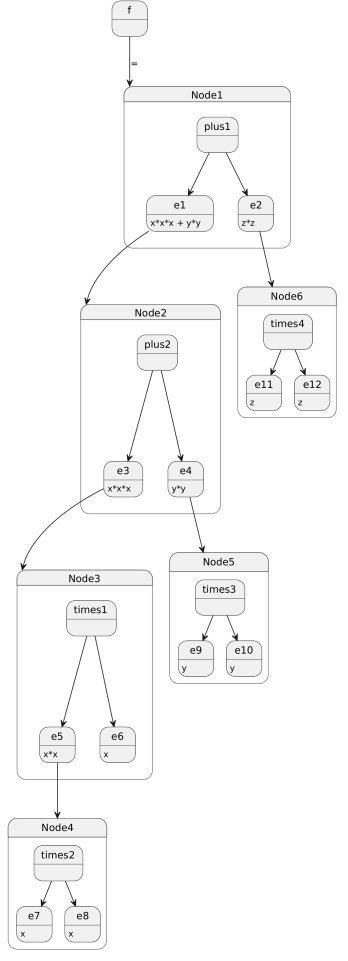

In [1]:
get_ast <- function(expression) {
    if(!is.call(expression)) {
        return(expression)
    }
    
    print(expression[[1]])
    print("Child Nr 1")
    print(expression[[2]])
    print("Child Nr 2")
    print(expression[[3]])
    cat("\n\n")
    
    expression <- as.list(expression)
    lapply(expression, get_ast)
}
expression <- quote(f <- x*x*x + y*y + z*z)
ast <- get_ast(expression)

`<-`
[1] "Child Nr 1"
f
[1] "Child Nr 2"
x * x * x + y * y + z * z


`+`
[1] "Child Nr 1"
x * x * x + y * y
[1] "Child Nr 2"
z * z


`+`
[1] "Child Nr 1"
x * x * x
[1] "Child Nr 2"
y * y


`*`
[1] "Child Nr 1"
x * x
[1] "Child Nr 2"
x


`*`
[1] "Child Nr 1"
x
[1] "Child Nr 2"
x


`*`
[1] "Child Nr 1"
y
[1] "Child Nr 2"
y


`*`
[1] "Child Nr 1"
z
[1] "Child Nr 2"
z




# Theory of reverse automatic differentiation

We will do the following we go over the expression using a modified version of the *get_ast* function. During each call we calculate the derivative of the node with respect to each of the children. For instance $\frac{\partial{Node1}} {\partial{child left}} = 1$. \
Afterwards we use the chain rule to calculate the final result. First a table which summarises the information we need (x is 2, y is 3 and z is 4).

In [2]:
df <- data.frame(
    Nodes =            c("Node1"        , "Node2"   , "Node3"  , "Node4"  , "Node5"  , "Node6"),
    Operation =        c("+"            , "+"       , "*"      , "*"      , "*"      , "*"     ),
    children_left =    c("x*x*x + y*y"  , "x*x*x"   , "x*x"    , "x"      , "y"      , "z"),
    children_right =   c("z*z"          , "y*y"     , "x"      , "x"      , "y"      , "z"),
    derivs_left =      c("1"            , "1"       , "x"      , "x"      , "y"      , "z"),
    derivs_right =     c("1"            , "1"       , "x*x"    , "x"      , "y"      , "z"),
    numeric_derivs =   c("[1, 1]"       , "[1, 1]"  , "[2, 4]" , "[2, 2]" , "[3, 3]" , "[4, 4]")
)

knitr::kable(df)



|Nodes |Operation |children_left |children_right |derivs_left |derivs_right |numeric_derivs |
|:-----|:---------|:-------------|:--------------|:-----------|:------------|:--------------|
|Node1 |+         |x*x*x + y*y   |z*z            |1           |1            |[1, 1]         |
|Node2 |+         |x*x*x         |y*y            |1           |1            |[1, 1]         |
|Node3 |*         |x*x           |x              |x           |x*x          |[2, 4]         |
|Node4 |*         |x             |x              |x           |x            |[2, 2]         |
|Node5 |*         |y             |y              |y           |y            |[3, 3]         |
|Node6 |*         |z             |z              |z           |z            |[4, 4]         |

Now we have to apply the chain rule. We start with $\frac{\partial{f}}{\partial{Node1}} = 1$. Next we have $\frac{\partial{Node1}}{\partial{leftChild}} = 1$. By multiplying these two we get: $\frac{\partial{f}}{\partial{Node1}}  \frac{\partial{Node1}}{\partial{leftChild}} = 1 * 1 = 1 = \frac{\partial{f}}{\partial{leftChild}}$. THis is done until we find a variable. Meaning and endpoint where only x, y or z is the child. Summing up all the endpoints for each child independtly results in the derivative for each children respectively. I have made a graph to show the entire process. 

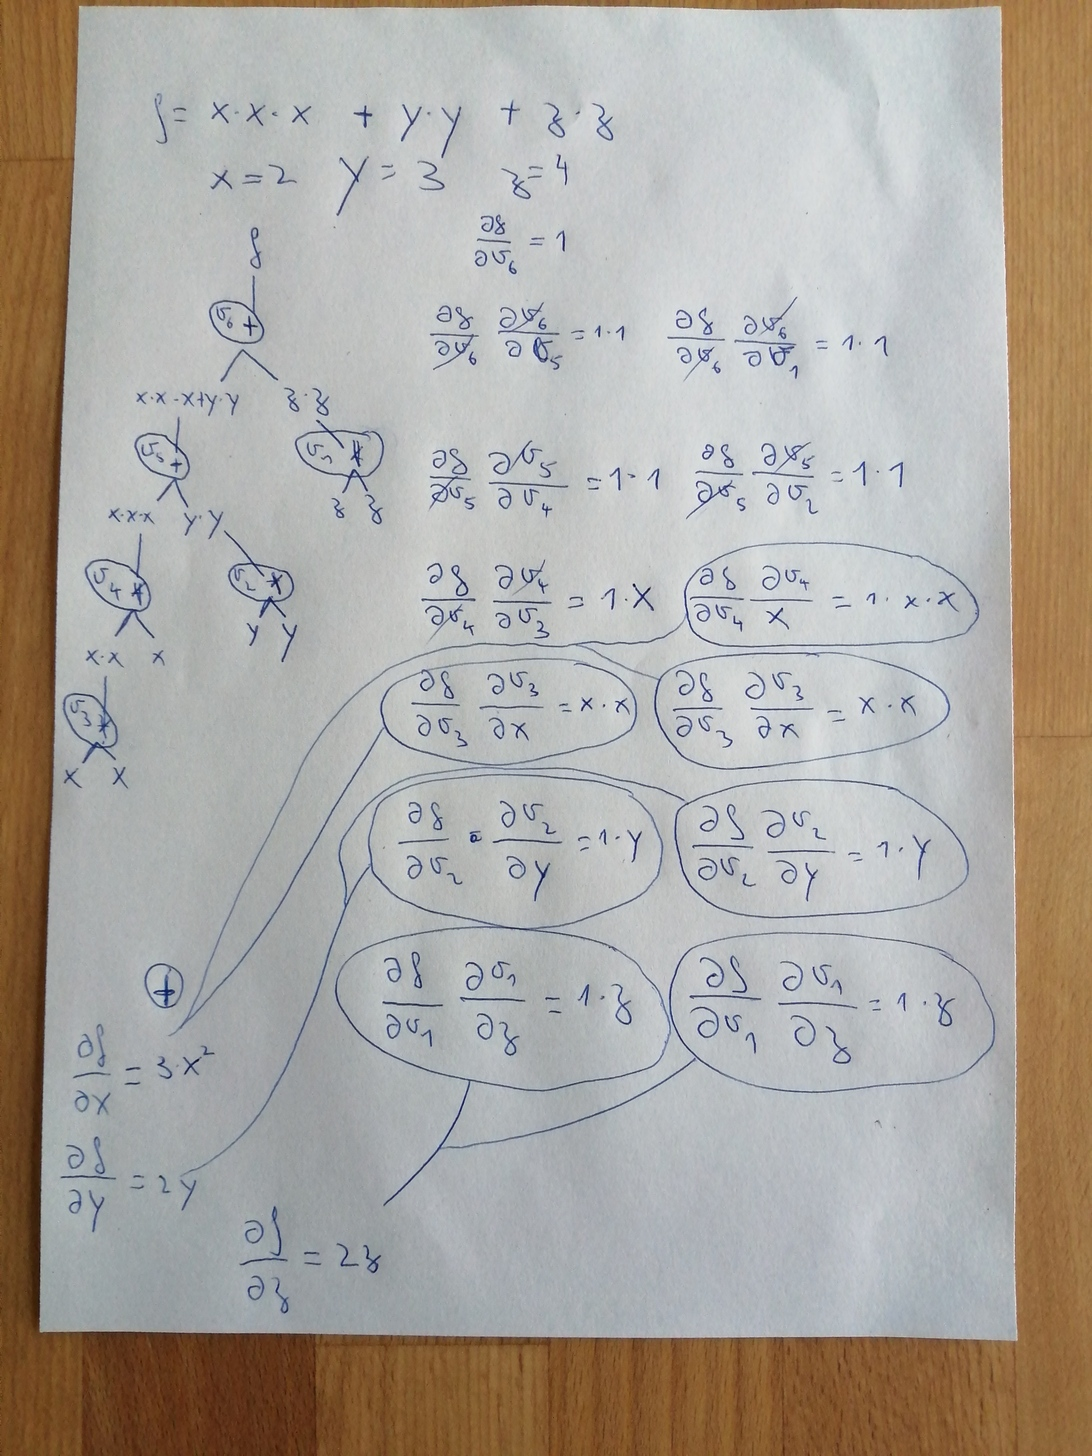

# Implementation of reverse AD

Assumptions/Simplifications:

- only binary functions
- only scalar values

In [175]:
is_variable <- function(node, var_list) {
  node <- c(deparse(node))
  node %in% var_list
}

which_variable <- function(node, var_list) {
  node <- c(deparse(node))
  which(node == var_list)
}

fill_association <- function(node, env) {
  if (is_variable(node, env$var_list)) {
    env$idx_vars_found <- c(env$idx_vars_found, env$counter)
    env$counter <- env$counter + 1
    which_var <- which_variable(node, env$var_list)
    env$which_vars_found <- c(env$which_vars_found, which_var)
  } else {
    env$which_vars_found <- c(env$which_vars_found, -1)
  } 
}

append_deriv <- function(expression, env) {
    e <- deparse(expression[[1]])
    if(e == "+") {
        env$tape <- c(env$tape, 1, 1)
    } else if(e == "*") {
        env$tape <- c(env$tape, eval(expression[[3]]), eval(expression[[2]]))
    } else if(e == "-") {
        env$tape <- c(env$tape, 1, -1)
    } else if(e == "/") {
        ex2 <- eval(expression[[2]])
        ex3 <- eval(expression[[3]])
        env$tape <- c(env$tape, 1/ex3, -ex2 / ex3^2 )
    } 
}

get_ast <- function(expression, env, idx, is_left) {
    if(!is.call(expression)) {
        return(expression)
    }
    if(length(expression) == 3) { # binary operation
        fill_association(expression[[2]], env)
        fill_association(expression[[3]], env) 
        env$num_args <- c(env$num_args, 2) 
        append_deriv(expression, env)
    } 
    expression <- as.list(expression)
    env$indices <- c(env$indices, idx)
    env$is_left <- c(env$is_left, is_left)
    get_ast(expression[[1]], env, idx, -1)
    idx <- idx + 1
    get_ast(expression[[2]], env, idx, TRUE)
    get_ast(expression[[3]], env, idx, FALSE)
}

deriv <- function(expression) {
    vars <- all.vars(expression)
    derivs <- numeric(length(vars))
    env <- new.env()
    env$counter <- 0
    env$idx_vars_found <- c()
    env$which_vars_found <- c()
    env$var_list <- vars
    env$tape <- c(1, 1)
    env$indices <- c()
    env$is_left <- c()
    ast <- get_ast(expression, env, 1, 1) # it does not matter whether it is the left or right child here
    #env$tape = the values listed in the table above
    env$is_left <- ifelse(env$is_left == 1, 1, 1)
    parent_indices <- env$indices - 1 # we stored the current node index. -1 to get the parent index
    is_left <- env$is_left
    derivs <- c()
    tape <- env$tape
    print(tape)
    for(i in 1:length(parent_indices)) {
        pi <- parent_indices[[i]]
        lc <- is_left[[i]]
        derivs <- c(derivs, tape[(i*2 + 1):(i*2 + 2)] * tape[pi*2 + lc])
    }
    n_vars <- unique(env$which_vars_found)
    n_vars <- n_vars[n_vars != -1]
    n_vars <- length(n_vars)
    deriv_result <- vector(length = n_vars)
    for(i in seq_along(1:length(env$which_vars_found))) {
        idx <- env$which_vars_found[[i]]
        if(idx != -1) {
            deriv_result[idx] <- deriv_result[idx] + derivs[[i]]
        }
    }
    return(deriv_result)
}

x <- 2
y <- 3
z <- 4
expression <- quote(x*x*x + y*y + z*z)
deriv(expression)

expression <- quote(x + y*z)
deriv(expression) # df/dx = 1; df/dy = z = 4; df/dz = y = 3 
    
expression <- quote(z/x)
deriv(expression) # df/dz = 1/x = 1/2; df/dx = -z/x^2 = -4/4 = -1
    
expression <- quote(y*x*x - x)
deriv(expression) # df/dx = 11; df/dy = 4    


 [1] 1 1 1 1 1 1 2 4 2 2 3 3 4 4


[1] 12  6  8

[1] 1 1 1 1 4 3


[1] 1 4 3

[1]  1.0  1.0  0.5 -1.0


[1]  0.5 -1.0

[1]  1  1  1 -1  2  6  2  3


[1]  4 11